# Generative modelling in deep learning

# <center> Antoine Dargier </center>
# <center> Thomas Douilly </center>
## <center> 04/04/2023 </center>

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

> First, we can use statistical metrics to compare two given distributions:
> * Mean and Variance
> * Skewness and Kurtosis: Skewness measures the asymmetry of a distribution, while kurtosis measures its "peakedness"
>
> We can also perform tests on the distribution, such as Kolmogorov-Smirnov Test or Chi-squared Test.
>
> Finally, there are other metrics to compare distributions, such as for example: 
> * the Kullback-Leibler divergence, define as: $\displaystyle D_{KL}(p_D||p_\theta) = \int_{-\infty}^{+\infty}p_d(x)log(\frac{p_D(x)}{p_\theta(x)}) \mathrm{d}x$, 
> * the Jensen Shanon Divergence, that we will see later,
> * Cross-entropy: $CE(p_D, p_\theta) = -\sum_{x} p_D(x)\log(p_\theta(x))$
> * the Maximum Mean Discrepancy (MMD): $MMD(p_D, p_\theta) = sup_\phi (\mathbb{E}_{p_D}[\phi(x)] - \mathbb{E}_{p_\theta}[\phi(x)] )$

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

> For density-based methods, their main drawback is that we need to know their formulation to compute them. In general, we don't know it and so it requires density estimation and discretization of the space, which can be very expensive in high dimension. Morevover, they can be highly sensitive to the sample size: even small differences between the distributions can be detected, even if they are not relevant. These methods can be computationally expensive and highly sensitive to outliers. 
>
> For values-based methods, they have a lot of advantages: they are less sensitive to sample size, they can be computed quickly, they are more robust to outliers, and often more easily interpretable. But they can be less efficient when comparing complex or non-parametric distributions. Moreover, the computation of $p_\theta$ can be very expensive in high dimension.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

> N can have a lot of different impacts on the computation and results. It can impact computation time and memory requirements. Larger N can result in more complex networks and slower training times. N can also impact the diversity of generated samples, and thus their quality. In fact, larger values of N can result in a wider range of possible samples. So it is important to carefully consider the trade-offs and choose an appropriate value for N based on the specific task and dataset.

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] \tag{1.1}$$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

> If the two distributions are totally different, the JSD gradient may be very small or even zero, making it difficult for the generator to learn effectively. This can result in vanishing gradients and slow or non-existent learning.

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) \tag{1.2}$.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

> This can cause a problem known as "the saturation problem": it occurs when the generator produces samples that are very close to the real data, but not quite perfect. In such cases, the discriminator's output is very close to 1,and the loss function $L_G$ becomes very small, approaching zero. This small gradient can result in the generator learning very slowly or not at all, making it difficult to improve the quality of generated samples.
>
> Another problem is that it can lead to overfitting and a very good model only on the generated samples. To overcome this problem, it is important to alternate between the learning of the generator and the discriminator.

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from sklearn import datasets
import numpy as np

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

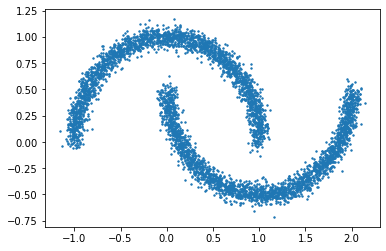

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [3]:
# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 2)
        
    def __call__(self, z):
        return self.fc1(z)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 1)
    
    def __call__(self, x):
        return self.fc1(x)

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

step 0: discriminator: 1.409e+00, generator: -6.804e-01
step 1000: discriminator: 1.393e+00, generator: -6.943e-01
step 2000: discriminator: 1.386e+00, generator: -6.931e-01
step 3000: discriminator: 1.386e+00, generator: -6.931e-01
step 4000: discriminator: 1.387e+00, generator: -6.934e-01
step 5000: discriminator: 1.386e+00, generator: -6.932e-01
step 6000: discriminator: 1.386e+00, generator: -6.931e-01
step 7000: discriminator: 1.386e+00, generator: -6.921e-01
step 8000: discriminator: 1.387e+00, generator: -6.934e-01
step 9000: discriminator: 1.387e+00, generator: -6.930e-01
step 10000: discriminator: 1.387e+00, generator: -6.934e-01
step 11000: discriminator: 1.387e+00, generator: -6.927e-01
step 12000: discriminator: 1.386e+00, generator: -6.932e-01
step 13000: discriminator: 1.387e+00, generator: -6.933e-01
step 14000: discriminator: 1.386e+00, generator: -6.947e-01
step 15000: discriminator: 1.387e+00, generator: -6.916e-01
step 16000: discriminator: 1.386e+00, generator: -6.9

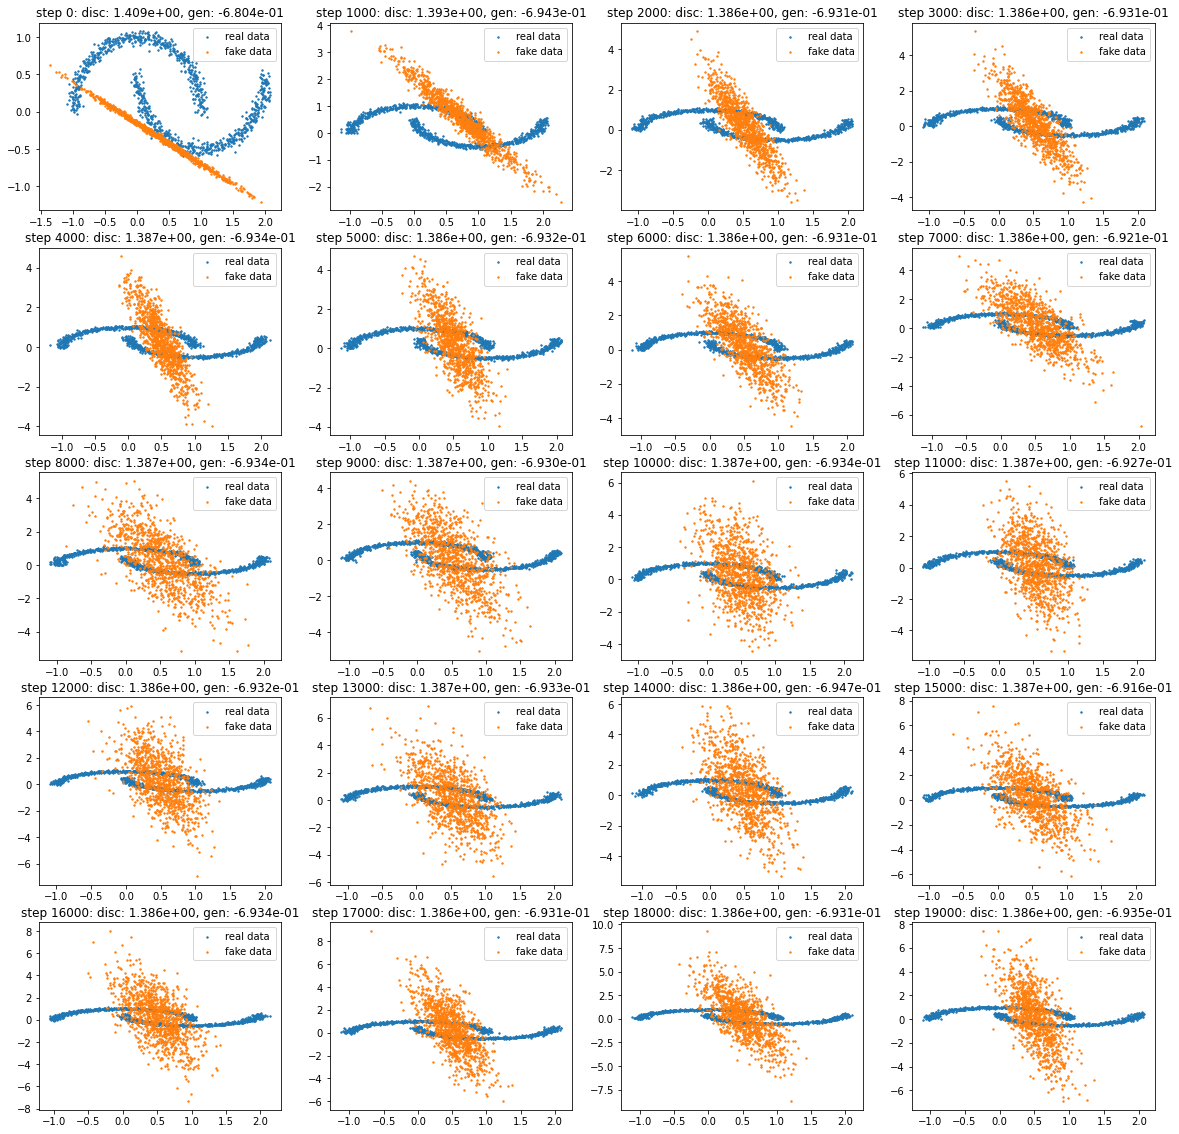

In [15]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 19001
# Batch size to use
BATCHLEN = 128

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

plt.figure(figsize=(20,20))
for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE DISCRIMINATOR LOSS HERE ==, equation 1.1
        disc_real_batch = discriminator(real_batch)
        disc_fake_batch = discriminator(fake_batch)
        disc_loss = F.softplus(-disc_real_batch) + F.softplus(disc_fake_batch)
        disc_loss = disc_loss.mean() 
        #
        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    #
    # == COMPUTE THE GENERATOR LOSS HERE, equation 1.2
    gen_fake_batch = discriminator(fake_batch)
    gen_loss = -F.softplus(gen_fake_batch)
    gen_loss = gen_loss.mean()
    #
    gen_loss.backward()
    optim_gen.step()
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        t = int(i/1000)
        plt.subplot(5,4,t+1)
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.title('step {}: disc: {:.3e}, gen: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        
        
plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> When discriminator is trained very well, the discriminator's output will be close to 1 and so the generator loss will tend to $-\infty$: it is gradient vanishing. To solve this problem, the loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ can be used. Indeed, this loss is always positive, so the generator will not totally collapse at the beginning.

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ] \tag{1.3}$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

In [4]:
# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class New_Generator(nn.Module):
    def __init__(self, gen_width, gen_depth):
        super().__init__()
        self.width = gen_width
        self.depth = gen_depth
        self.layers = nn.ModuleList()
        
        self.fc1 = nn.Linear(PRIOR_N, self.width)
        for i in range (self.depth):
            self.layers.append(nn.Linear(self.width, self.width))
        self.fcn = nn.Linear(self.width, 2)
        
    def __call__(self, z):
        z = F.relu(self.fc1(z))
        for layer in self.layers:
            z = F.relu(layer(z))
        z = self.fcn(z)
        return z
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class New_Discriminator(nn.Module):
    def __init__(self, disc_width, disc_depth):
        super().__init__()
        self.width = disc_width
        self.depth = disc_depth
        self.layers = nn.ModuleList()
        
        self.fc1 = nn.Linear(2, self.width)
        for i in range (self.depth):
            self.layers.append(nn.Linear(self.width, self.width))
        self.fcn = nn.Linear(self.width, 1)
    
    def __call__(self, x):
        x = F.relu(self.fc1(x))
        for layer in self.layers:
            x = F.relu(layer(x))
        x = self.fcn(x)
        return x

In [7]:
# Total number of training iterations for the generator
N_ITER = 10001
# Batch size to use
BATCHLEN = 128

def train_gan(TRAIN_RATIO=1, gen_depth=3, gen_width=100, disc_depth=3, disc_width=100):
    
    generator = New_Generator(gen_width, gen_depth)
    optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
    discriminator = New_Discriminator(disc_width, disc_depth)
    optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

    for i in range(N_ITER):
        # train the discriminator
        for _ in range(TRAIN_RATIO):
            discriminator.zero_grad()
            real_batch = generate_batch(BATCHLEN)
            fake_batch = generator.generate(BATCHLEN)
            #
            # == COMPUTE THE DISCRIMINATOR LOSS HERE ==, equation 1.1
            disc_real_batch = discriminator(real_batch)
            disc_fake_batch = discriminator(fake_batch)
            disc_loss = F.softplus(-disc_real_batch) + F.softplus(disc_fake_batch)
            disc_loss = disc_loss.mean() 
            #
            disc_loss.backward()
            optim_disc.step()
        # train the generator
        generator.zero_grad()
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE GENERATOR LOSS HERE, equation 1.3
        gen_fake_batch = discriminator(fake_batch)
        gen_loss = F.softplus(-gen_fake_batch)
        gen_loss = gen_loss.mean()
        #
        gen_loss.backward()
        optim_gen.step()
    
    real_batch = generate_batch(1024)
    fake_batch = generator.generate(1024).detach()
    return real_batch, fake_batch, disc_loss, gen_loss

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


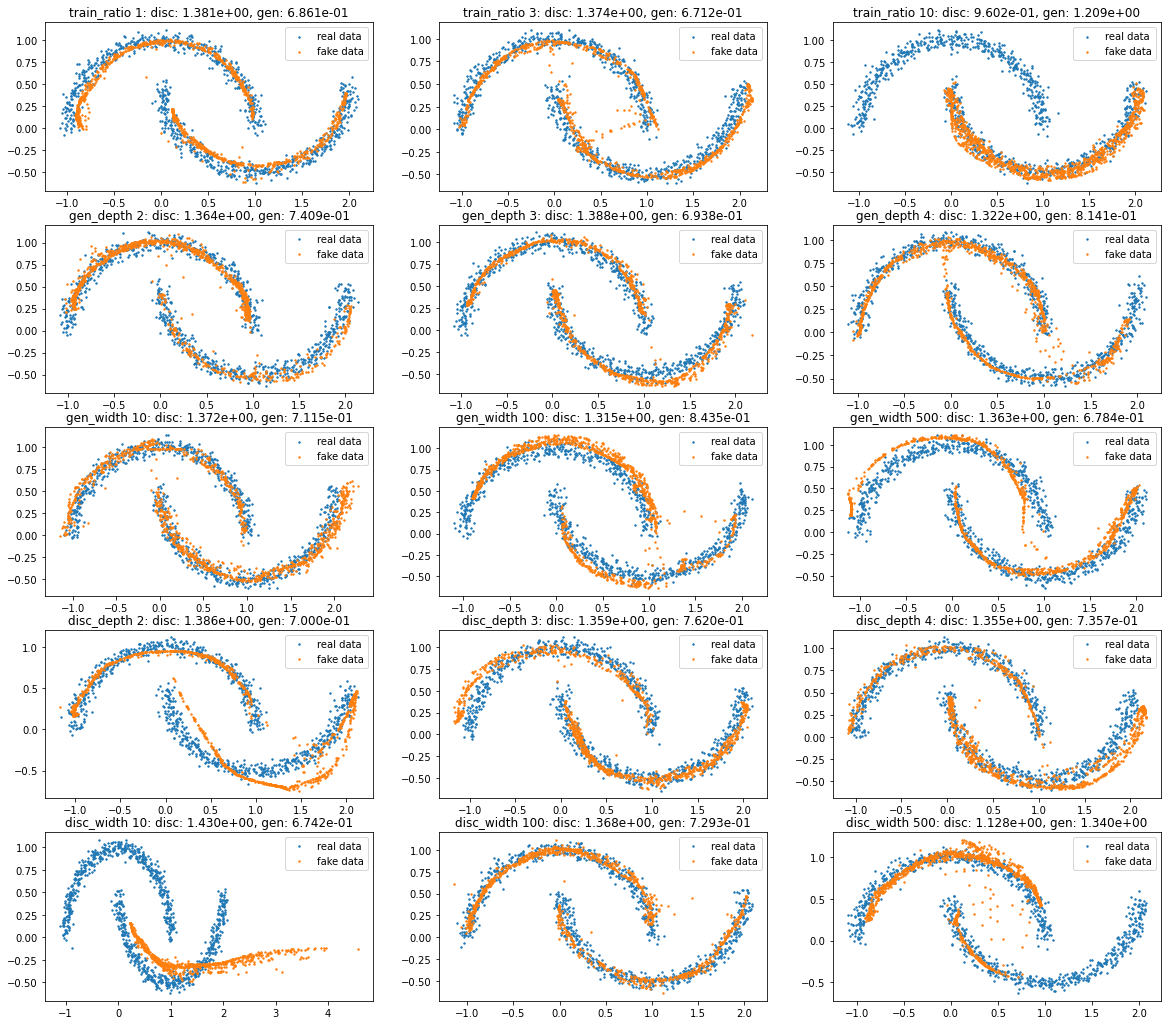

In [8]:
# Define list of values to test
TRAIN_RATIOS = [1, 3, 10]
gen_depths = [2, 3, 4]
gen_widths = [10, 100, 500]
disc_depths = [2, 3, 4]
disc_widths =[10, 100, 500]

plt.figure(figsize=(20,18))
t=0
for TRAIN_RATIO in TRAIN_RATIOS:
    real_batch, fake_batch, disc_loss, gen_loss = train_gan(TRAIN_RATIO=TRAIN_RATIO)
    plt.subplot(5,3,t+1)
    plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
    plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
    plt.legend()
    plt.title('train_ratio {}: disc: {:.3e}, gen: {:.3e}'.format(TRAIN_RATIO, float(disc_loss), float(gen_loss)))
    t+=1
    print(t)
for gen_depth in gen_depths:
    real_batch, fake_batch, disc_loss, gen_loss = train_gan(gen_depth=gen_depth)
    plt.subplot(5,3,t+1)
    plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
    plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
    plt.legend()
    plt.title('gen_depth {}: disc: {:.3e}, gen: {:.3e}'.format(gen_depth, float(disc_loss), float(gen_loss)))
    t+=1
    print(t)
for gen_width in gen_widths:
    real_batch, fake_batch, disc_loss, gen_loss = train_gan(gen_width=gen_width)
    plt.subplot(5,3,t+1)
    plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
    plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
    plt.legend()
    plt.title('gen_width {}: disc: {:.3e}, gen: {:.3e}'.format(gen_width, float(disc_loss), float(gen_loss)))
    t+=1
    print(t)
for disc_depth in disc_depths:
    real_batch, fake_batch, disc_loss, gen_loss = train_gan(disc_depth=disc_depth)
    plt.subplot(5,3,t+1)
    plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
    plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
    plt.legend()
    plt.title('disc_depth {}: disc: {:.3e}, gen: {:.3e}'.format(disc_depth, float(disc_loss), float(gen_loss)))
    t+=1
    print(t)
for disc_width in disc_widths:
    real_batch, fake_batch, disc_loss, gen_loss = train_gan(disc_width=disc_width)
    plt.subplot(5,3,t+1)
    plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
    plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
    plt.legend()
    plt.title('disc_width {}: disc: {:.3e}, gen: {:.3e}'.format(disc_width, float(disc_loss), float(gen_loss)))
    t+=1
    print(t)
plt.show()

> With a first overview, we can first say that we achieve very good performances with fake data very close to real ones. For our model, we use as default parameters a $train ratio = $, $generator depth=3$, $generator width=100$, $discriminator depth=3$, $discriminator width=100$, and we make one of these five parameters vary. Here are the analysis of the imapct of each one:
>
> * train ratio : the higher the train ratio, the smaller the discriminator loss and the higher the generator loss. With an important train ratio, the discriminator learns well and quick, but the generator training can be slow and the train can vanish.
>
> * generator depth : it seems to having a huge impact in our case. We can however say that there is a trade-off to find with the generator depth: not so high to be trained quickly and easily, and not so low to have enough capabilities to generate the samples.
>
> * generator width : we can see that we have the best performances with the lowest width (10). That is again probably because we reach faster the optimal solution with low values. In reality, the width need to be sufficient too to have enough power to the generator.
>
> * discriminator depth : with the discriminator depth, we can see that the plot are very different from one graph to another. The losses aren't very different, but we can see that the discriminator loss descreases when the depth increases, and the generator loss increases before decreases. When the generator loss is close to its objective, it can more likely vanish.
>
> * discriminator width : we see here clearly that there is a trade-off to find. When increasing, the disciminator loss decreases and the generator loss increases for the same reasons: if it is too low, the discriminator loss is not good, and if it is too high, its gradient can vanish.

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

> $$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right] = \mathbb{E}_{p_D}\left[ log(p_D) \right] - \mathbb{E}_{p_D}\left[ log(p_\theta) \right]$$
>
> As the first term of the sum is not dependent on $\theta$, we have:
>
> $$min_\theta D_{KL}(p_D \| p_\theta)  \Leftrightarrow max_\theta \mathbb{E}_{p_D}\left[ log(p_\theta) \right]$$

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> If $p(z)$ is not sampled during the training process a problem can be that the encoder may not learn to map the input data to the full range of the latent space. This can cause the decoder to generate outputs that do not correspond to any meaningful data, as it may not have learned how to generate the corresponding latent variable.

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

> $$ q_\phi(z | x) \sim \mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x))) \Rightarrow q_\phi(z | x) = \frac{1}{\sqrt{(2\pi)^k |Diag(\sigma_\phi^2(x))|}}\exp[{\frac{-1}{2}(z-\mu_\phi(x))^TDiag(\sigma_\phi^2(x))^{-1}(z-\mu_\phi(x))}]$$
and $$ p(z) \sim \mathcal{N}(0; Id) \Rightarrow p(z) = \frac{1}{\sqrt{(2\pi)^k}}\exp[\frac{-1}{2}z^Tz]$$
>
> We will write the equation for two Gaussian distribution: 
> let $$p(x) \sim \mathcal{N}(\mu_1; \sigma_1)$$ and $$ q(x) \sim \mathcal{N}(\mu_2; \sigma_2)$$
>
> $$D_{KL}(p(x) \| q(x)) = -\int p(x)\log q(x) dx + \int p(x)\log p(x) dx $$
>
> with integration formula, we know that: $\int p(x)\log p(x) dx = -\frac{1}{2}(1+log(2\pi\sigma_1^2))$.
>
> On the other side, $$- \int p(x)\log q(x) dx = - \int p(x).\log[ \frac{1}{\sqrt{(2\pi\sigma_2^2)}}\exp[-\frac{(x-\mu_2)^2}{2\sigma_2^2}]]dx = \frac{1}{2}\log(2\pi\sigma_2^2) + \int p(x)\frac{(x-\mu_2)^2}{2\sigma_2^2}dx = \frac{1}{2}\log(2\pi\sigma_2^2) + \frac{1}{2\sigma_2^2}(\int p(x) x^2 dx + -2\mu_2\int x.p(x) dx + \mu_2^2\int p(x) dx) = \frac{1}{2}\log(2\pi\sigma_2^2) + \frac{\sigma_1^2 + \mu_1^2 -2\mu_1\mu_2 + \mu_2^2}{2\sigma_2^2}$$
>
> Finally, we obtain: $$ D_{KL}(p(x) \| q(x)) = log(\frac{\sigma_2}{\sigma_1}) + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2\sigma_2^2} -\frac{1}{2} $$
>
> When $\sigma_2 = 1$ and $\mu_2 = 0$, we got: $$ D_{KL}(p(x) \| q(x)) = -log(\sigma_1) + \frac{1}{2}\sigma_1^2 + \frac{1}{2}\mu_1^2 -\frac{1}{2} = \frac{1}{2}(\mu_1^2 + \sigma_1^2 - log(\sigma_1^2) -1)$$
>
> We can know insert our parameters for $q_\phi(z | x)$ and $p(z)$, and use the formulation for vectors in $k$ dimensions (now, $\sigma_2 = 1$ and $\mu_2 = 0$):
>
> $$ D_{KL}(q_\phi(z | x) \| p(z)) = \frac{1}{2} \sum_{i=1}^{k} (\mu_{\phi_i(x)}^2 + \sigma_{\phi_i(x)}^2 - \log \sigma_{\phi_i(x)}^2 - 1) \tag{2.1}$$

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

> We have:
> 
> $$ p_\theta(x | z) \sim \mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z))) \Rightarrow p_\theta(x | z) = \frac{1}{\sqrt{(2\pi)^k |Diag(\sigma_\theta^2(z))|}}\exp[\frac{-1}{2}(x-\mu_\theta(z))^T Diag(\sigma_\theta^2(z))^{-1} (x-\mu_\theta(z))] $$
>
> Thus,
>
> $$ -\log p_\theta(x | z) = \frac{1}{2}[k\log(2\pi) + \log(|Diag(\sigma_\theta^2(z))|) + (x-\mu_\theta(z))^T Diag(\sigma_\theta^2(z))^{-1} (x-\mu_\theta(z))] \tag{2.2}$$

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [5]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(2, LATENT_N)
        self.fc_logvar = nn.Linear(2, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)
    
# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(LATENT_N, 2)
        self.fc_logvar = nn.Linear(LATENT_N, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

step 0: KL: 2.657e+02, rec: 2.744e+03
step 1000: KL: 2.028e+01, rec: 2.370e+03
step 2000: KL: 5.257e+01, rec: 2.321e+03
step 3000: KL: 6.203e+01, rec: 2.286e+03
step 4000: KL: 6.408e+01, rec: 2.294e+03
step 5000: KL: 6.524e+01, rec: 2.276e+03
step 6000: KL: 6.401e+01, rec: 2.276e+03
step 7000: KL: 6.183e+01, rec: 2.291e+03
step 8000: KL: 6.367e+01, rec: 2.292e+03
step 9000: KL: 6.468e+01, rec: 2.309e+03
step 10000: KL: 6.551e+01, rec: 2.297e+03
step 11000: KL: 6.386e+01, rec: 2.298e+03
step 12000: KL: 6.517e+01, rec: 2.285e+03
step 13000: KL: 6.580e+01, rec: 2.293e+03
step 14000: KL: 6.451e+01, rec: 2.292e+03
step 15000: KL: 6.326e+01, rec: 2.300e+03
step 16000: KL: 6.556e+01, rec: 2.304e+03
step 17000: KL: 6.675e+01, rec: 2.300e+03
step 18000: KL: 6.678e+01, rec: 2.290e+03
step 19000: KL: 6.532e+01, rec: 2.286e+03
step 20000: KL: 6.594e+01, rec: 2.284e+03
step 21000: KL: 6.747e+01, rec: 2.293e+03
step 22000: KL: 6.435e+01, rec: 2.295e+03
step 23000: KL: 6.480e+01, rec: 2.286e+03
step 

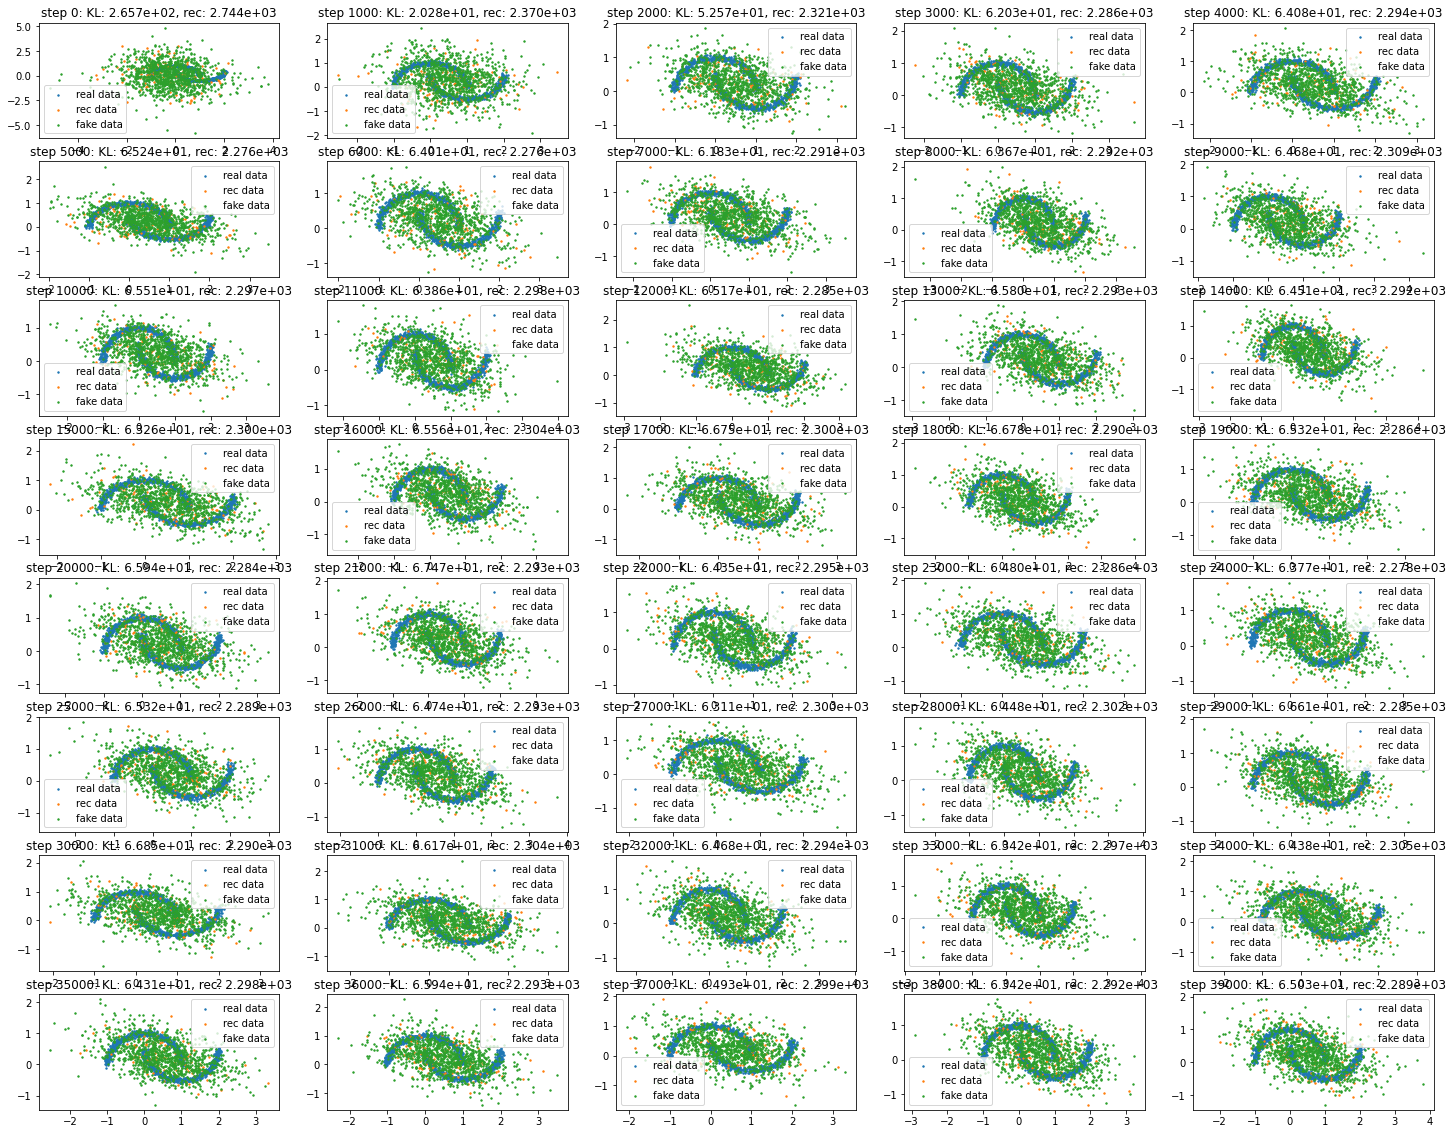

In [6]:
# Total number of training iterations for the VAE
N_ITER = 39001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

plt.figure(figsize=(25,20))
for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    loss_kl = 0.5 * torch.sum(torch.exp(enc_logvar) + enc_mu**2 - enc_logvar - 1) #equation 2.1
    # 
    # SAMPLE z FROM q(z|x) HERE
    #
    enc_sig = torch.exp(0.5*enc_logvar) #allow to find sigma from logvar
    z = enc_mu + enc_sig * torch.randn((BATCHLEN,LATENT_N)) #z = mu + sig.eps
    
    dec_mu, dec_logvar = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    loss_rec = 0.5 * torch.sum(LATENT_N * np.log(2 * np.pi) + dec_logvar + (x - dec_mu)**2 * torch.exp(-dec_logvar)) 
    #equqtion 2.2
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        t = int(i/1000)
        plt.subplot(8,5,t+1)
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.title('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        
plt.show()

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

For the same reasons as for the GAN, we will increase the width and depth of the encoder decoder to give more power and have better results. Moreover, we will fix $\sigma_\theta(z)$ to $1e-4$.

It seems very important here to have acceptable results to weight the losses for the backward. Use a weighting factor of 0.25 for the KL divergence loss and 1 for the reconstruction loss is a common choice of weighting factors in VAEs and is used to balance the contribution of the two losses during training.

In [5]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class New_Encoder(nn.Module):
    def __init__(self, enc_depth, enc_width):
        super().__init__()
        self.width = enc_width
        self.depth = enc_depth
        self.layers = nn.ModuleList()
        
        self.fc1 = nn.Linear(2, self.width)
        for i in range (self.depth):
            self.layers.append(nn.Linear(self.width, self.width))
        
        self.fc_mu = nn.Linear(self.width, LATENT_N)
        self.fc_logvar = nn.Linear(self.width, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        x = F.relu(self.fc1(x))
        for layer in self.layers:
            x = F.relu(layer(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)
    

# Define the discriminator
class New_Decoder(nn.Module):
    def __init__(self, dec_depth, dec_width):
        super().__init__()
        self.width = dec_width
        self.depth = dec_depth
        self.layers = nn.ModuleList()
        
        self.fc1 = nn.Linear(LATENT_N, self.width)
        for i in range (self.depth):
            self.layers.append(nn.Linear(self.width, self.width))
        
        self.fc_mu = nn.Linear(self.width, 2)
        self.fc_logvar = nn.Linear(self.width, 2)
        
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        z = F.relu(self.fc1(z))
        for layer in self.layers:
            z = F.relu(layer(z))
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, 1e-4)

step 0: KL: 3.866e+00, rec: 2.431e+03
step 1000: KL: 3.629e+02, rec: 1.976e+03
step 2000: KL: 4.309e+02, rec: 2.178e+03
step 3000: KL: 4.454e+02, rec: 1.906e+03
step 4000: KL: 4.614e+02, rec: 2.100e+03
step 5000: KL: 4.672e+02, rec: 1.983e+03
step 6000: KL: 5.203e+02, rec: 1.978e+03
step 7000: KL: 4.988e+02, rec: 1.765e+03
step 8000: KL: 5.303e+02, rec: 1.738e+03
step 9000: KL: 5.316e+02, rec: 1.696e+03
step 10000: KL: 5.136e+02, rec: 1.767e+03
step 11000: KL: 5.368e+02, rec: 1.761e+03
step 12000: KL: 5.389e+02, rec: 1.773e+03
step 13000: KL: 5.573e+02, rec: 1.689e+03
step 14000: KL: 5.464e+02, rec: 1.653e+03
step 15000: KL: 5.602e+02, rec: 1.676e+03
step 16000: KL: 5.573e+02, rec: 1.698e+03
step 17000: KL: 5.436e+02, rec: 1.821e+03
step 18000: KL: 5.684e+02, rec: 1.779e+03
step 19000: KL: 5.690e+02, rec: 1.749e+03


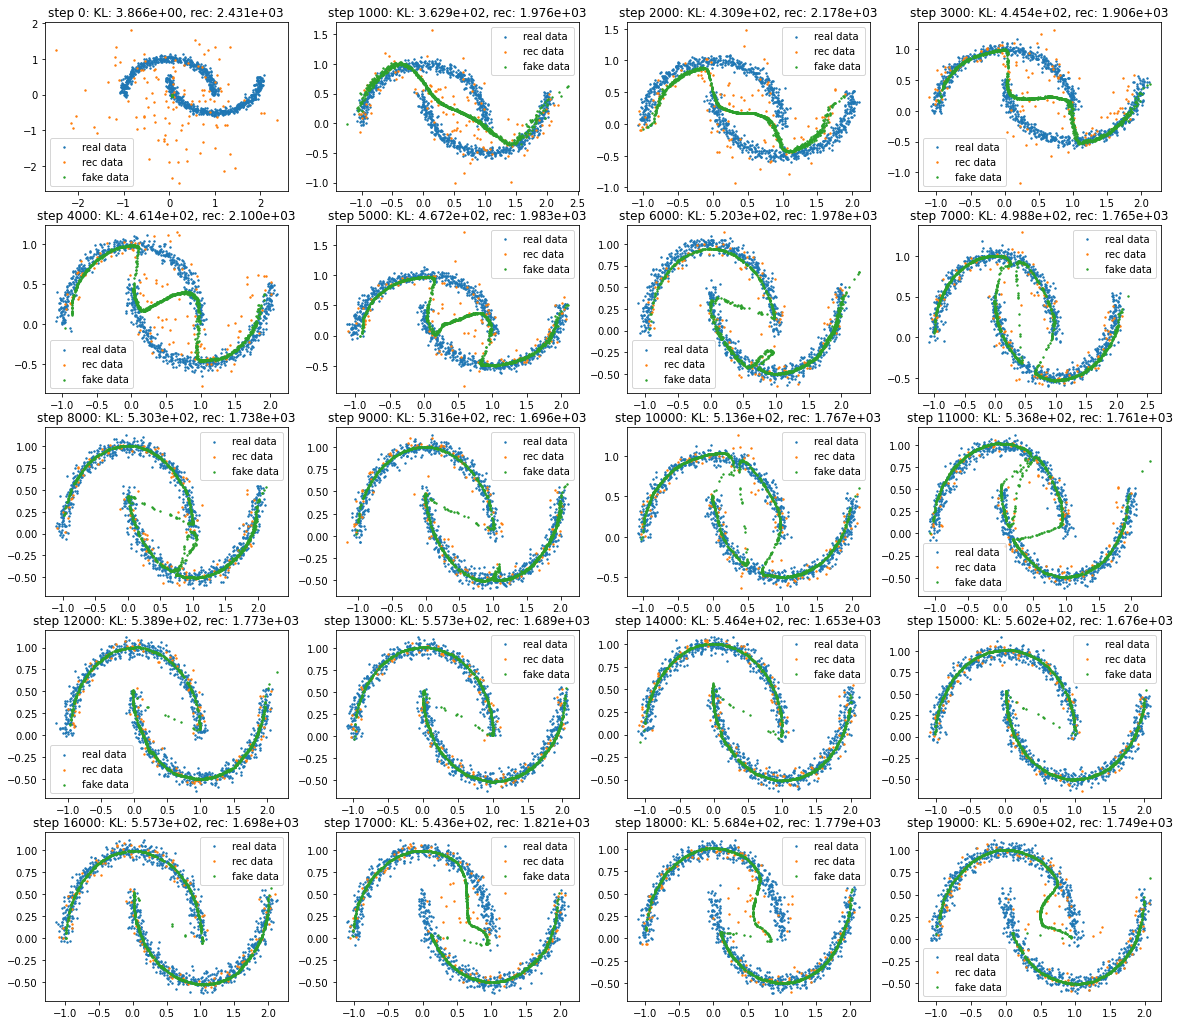

In [6]:
# Total number of training iterations for the VAE
N_ITER = 19001
# Batch size to use
BATCHLEN = 128

encoder = New_Encoder(enc_depth = 5, enc_width = 100)
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = New_Decoder(dec_depth = 5, dec_width = 100)
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

plt.figure(figsize=(20,18))
for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    loss_kl = 0.5 * torch.sum(torch.exp(enc_logvar) + enc_mu**2 - enc_logvar - 1) #equation 2.1
    # 
    # SAMPLE z FROM q(z|x) HERE
    #
    enc_sig = torch.exp(0.5*enc_logvar) #allow to find sigma from logvar
    z = enc_mu + enc_sig * torch.randn((BATCHLEN,LATENT_N)) #z = mu + sig.eps
    
    dec_mu, dec_logvar = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    loss_rec = 0.5 * torch.sum(LATENT_N * np.log(2 * np.pi) + dec_logvar + (x - dec_mu)**2 * torch.exp(-dec_logvar)) 
    #equqtion 2.2
    
    (0.25*loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        t = int(i/1000)
        plt.subplot(5,4,t+1)
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.title('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        
plt.show()

> First we can see that we got better performances with this new structure. That can be because now we just have to learn the mean of the distribution and no more its variance. So the complexity of the model is reduced. 
>
> We can see with the plots that the fake data and reconstruction data are very closed to the real data. However, the learning seems not stable and it seems very sensitive to parameters values. 

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

In [7]:
# Total number of training iterations for the VAE
N_ITER = 10001
# Batch size to use
BATCHLEN = 128

def train_vae(enc_depth=3, enc_width=100, dec_depth=3, dec_width=100):
    
    encoder = New_Encoder(enc_depth, enc_width)
    optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
    decoder = New_Decoder(dec_depth, dec_width)
    optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

    for i in range(N_ITER):
        encoder.zero_grad()
        decoder.zero_grad()
    
        x = generate_batch(BATCHLEN)
    
        enc_mu, enc_logvar = encoder(x)
        #
        # COMPUTE THE KL PART OF THE LOSS HERE
        #
        loss_kl = 0.5 * torch.sum(torch.exp(enc_logvar) + enc_mu**2 - enc_logvar - 1) #equation 2.1
        
        # 
        # SAMPLE z FROM q(z|x) HERE
        #
        enc_sig = torch.exp(0.5*enc_logvar) #to find sigma from logvar
        z = enc_mu + enc_sig * torch.randn((BATCHLEN,LATENT_N)) #z = mu + sig.eps
    
        dec_mu, dec_logvar = decoder(z)
        #
        # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
        #
        loss_rec = 0.5 * torch.sum(LATENT_N * np.log(2 * np.pi) + dec_logvar + (x - dec_mu)**2 * torch.exp(-dec_logvar)) 
        #equqtion 2.2
    
        (0.25*loss_kl + loss_rec).backward()
        optim_enc.step()
        optim_dec.step()
    
    real_batch = generate_batch(1024)
    rec_batch = torch.normal(dec_mu, 1e-4).detach()
    fake_batch = decoder.generate(1024).detach()
    
    return real_batch, rec_batch, fake_batch, loss_kl, loss_rec

1
2
3
4
5
6
7
8
9
10
11
12


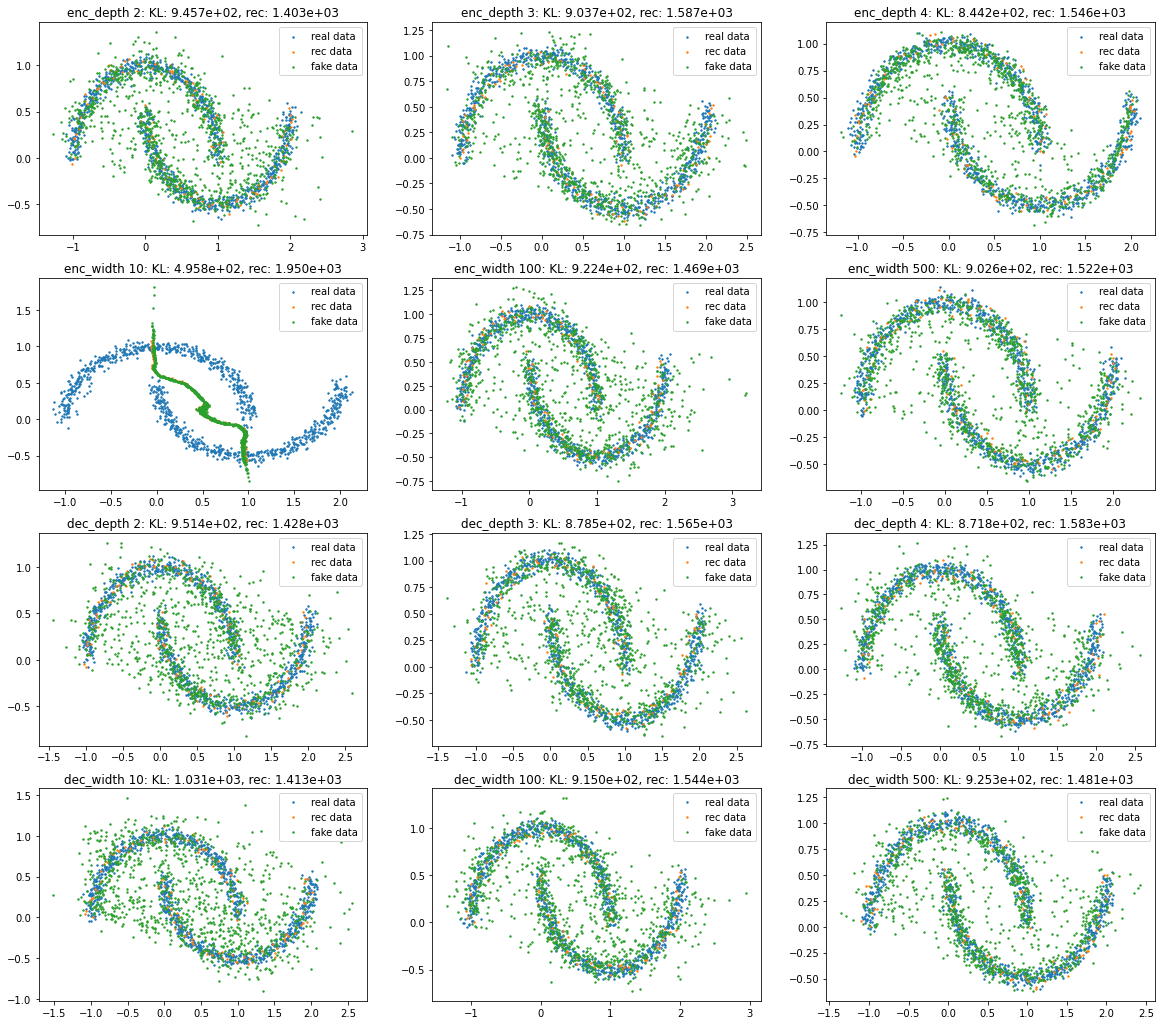

In [8]:
# Define list of values to test
enc_depths = [2, 3, 4]
enc_widths = [10, 100, 500]
dec_depths = [2, 3, 4]
dec_widths =[10, 100, 500]

plt.figure(figsize=(20,18))
t=0
for enc_depth in enc_depths:
    real_batch, rec_batch, fake_batch, loss_kl, loss_rec = train_vae(enc_depth=enc_depth)
    plt.subplot(4,3,t+1)
    plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
    plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
    plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
    plt.legend()
    plt.title('enc_depth {}: KL: {:.3e}, rec: {:.3e}'.format(enc_depth, float(loss_kl), float(loss_rec)))
    t+=1
    print(t)
for enc_width in enc_widths:
    real_batch, rec_batch, fake_batch, loss_kl, loss_rec = train_vae(enc_width=enc_width)
    plt.subplot(4,3,t+1)
    plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
    plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
    plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
    plt.legend()
    plt.title('enc_width {}: KL: {:.3e}, rec: {:.3e}'.format(enc_width, float(loss_kl), float(loss_rec)))
    t+=1
    print(t)
for dec_depth in dec_depths:
    real_batch, rec_batch, fake_batch, loss_kl, loss_rec = train_vae(dec_depth=dec_depth)
    plt.subplot(4,3,t+1)
    plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
    plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
    plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
    plt.legend()
    plt.title('dec_depth {}: KL: {:.3e}, rec: {:.3e}'.format(dec_depth, float(loss_kl), float(loss_rec)))
    t+=1
    print(t)
for dec_width in dec_widths:
    real_batch, rec_batch, fake_batch, loss_kl, loss_rec = train_vae(dec_width=dec_width)
    plt.subplot(4,3,t+1)
    plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
    plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
    plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
    plt.legend()
    plt.title('dec_width {}: KL: {:.3e}, rec: {:.3e}'.format(dec_width, float(loss_kl), float(loss_rec)))
    t+=1
    print(t)
plt.show()

> It was difficult to train the VAE more, with more iterations or bigger depths and widths because of computational limitations. The training for these 12 outputs has already lasted hours.
>
> First, the capacity of the encoder and decoder play an important role. If the encoder or decoder is too weak, it may not be able to model the data distribution effectively, leading to poor reconstruction quality and/or poor latent space representations. But if the encoder or decoder has too much capacity, it may overfit the training data and fail to generalize to new data. This can be mitigated by adding regularization techniques such as dropout or weight decay.
>
> This will have important consequences on the training process, because if the encoder or decoder is too powerful, the optimization process may be slow or unstable. On the other hand, if it is too weak, it may be difficult to optimize the model effectively. 
>
> So, we need to find a trade-off between performances and computational time to choose the best parameters and an acceptable power of encoder and decoder.

### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_\mathcal{N} = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_G$ this obtained distribution, that is, the image of $p_\mathcal{N}$ through $f^{-1}$: $p_G$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_G$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$. 
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

**Q14: Justify the above equality**

> $$ \int p_X(x)dx = \int p_Z(z)= 1 \Leftrightarrow p_X(x) = p_Z(z) |\frac{dz}{dx}| =  p_Z(f(x)) |\frac{df(x)}{dx}| $$
>
> In the multivariate case, the derivative becomes a Jacobian of which we need to take the determinant:
>
> $$ p_X(x) = p_Z(f(z)).\det J_f \Rightarrow \log(p_X(x)) = \log(p_Z(f(z))) + \log \det J_f $$

Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

**Q15: Express this loss as a (very simple) function of the quantity above.**

> As in question Q8., from the Kullback-Leibler divergence, we can create the following loss:
>
> $$ Loss = - \mathbb{E}_{p_D}[log(p_X(x))] = - \mathbb{E}_{p_D}[\log(p_Z(f(z))) + \log \det J_f] $$

A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
![real NVP diagram](realNVPforward.png)

**Q16: Show that the defined mapping is indeed invertible**

> We have to show that from $y_{1:d}$ and $y_{d+1:D}$, we can reconstruct $x_{1:d}$ and $x_{d+1:D}$.
>
> First, $$y_{1:d} = x_{1:d} \Rightarrow x_{1:d} = y_{1:d}$$
>
> Secondly, $$ y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d}) $$
> $$ \Rightarrow x_{d+1:D}\odot \exp(s(x_{1:d})) \odot \exp(-s(x_{1:d})) = (y_{d+1:D} - t(x_{1:d}) \odot \exp(-s(x_{1:d})) $$
> $$ \Rightarrow x_{d+1:D} = (y_{d+1:D} - t(y_{1:d}) \odot \exp(-s(y_{1:d}))$$
>
> So the defined mapping is invertible.

**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

> $$ J_f = \frac{\partial y}{\partial x} = \begin{pmatrix}
\frac{\partial y_{1:d}}{\partial x_{1:d}} & \frac{\partial y_{1:d}}{\partial x_{d+1:D}} \\
\frac{\partial y_{d+1:D}}{\partial x_{1:d}} & \frac{\partial y_{d+1:D}}{\partial x_{d+1:D}} \\
\end{pmatrix} $$
>
> However, $\frac{\partial y_{1:d}}{\partial x_{d+1:D}} = 0$, so the matrix is diagonal, and thus his determinant is the product of the elements on the diagonal.
>
> We have $\frac{\partial y_{1:d}}{\partial x_{1:d}} = 1$ and as we have $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$, $\frac{\partial y_{d+1:D}}{\partial x_{d+1:D}} = Diag(\exp(s(x_{1:d})))$.
>
> So, finally, $$ \det J_f = \prod_j \exp(s(x_{1:d})_j) = \exp(\sum_j s(x_{1:d})_j)$$

**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [11]:
import torch
from torch import nn
from torch.nn import functional as F


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
        super().__init__()
        ### define here variables to use in f and s ###
        self.s = nn.Sequential(nn.Linear(input_size,hidden_size),
                              nn.ReLU(inplace = True),
                              nn.Linear(hidden_size,hidden_size),
                              nn.ReLU(inplace = True), 
                              nn.Linear(hidden_size,output_size),
                              nn.Tanh()
                              )
        
        self.t = nn.Sequential(nn.Linear(input_size,hidden_size),
                              nn.ReLU(inplace = True),
                              nn.Linear(hidden_size,hidden_size),
                              nn.ReLU(inplace = True), 
                              nn.Linear(hidden_size,output_size),
                              )
        ###
        self.mask = mask #we use the mask variable to make the cut in input

    def sfun(self, x_m):
        x_m = self.s(x_m)
        return x_m
        
    def tfun(self, x_m):
        x_m = self.t(x_m)
        return x_m
        
    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        y_m = y * self.mask
        y = torch.exp(-self.sfun(y_m)) * ((1 - self.mask) * y - self.tfun(y_m)) + y_m
        return y

In [12]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [13]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [14]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8

In [15]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [16]:
from torch import distributions # optim, 
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.021206
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.038085
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.048110
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.050717
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.053921
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.054738
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.056234
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.056339
====> Epoch: 1 Average train loss: -0.0477


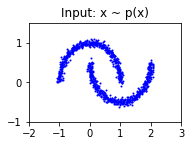

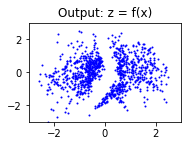

====> Test loss: -0.0583


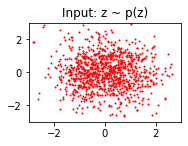

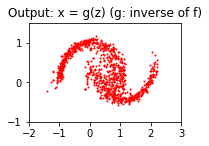

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.057345
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.057106
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.057981
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.057220
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.057275
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.057054
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.057787
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.057298
====> Epoch: 2 Average train loss: -0.0575


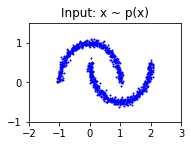

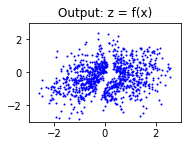

====> Test loss: -0.0595


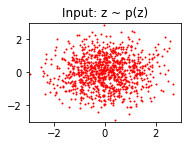

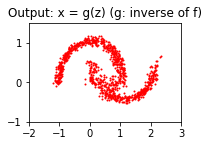

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.057187
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.057658
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.058154
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.059586
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.058105
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.058536
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.058485
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.058711
====> Epoch: 3 Average train loss: -0.0584


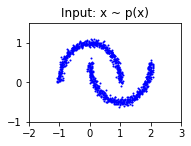

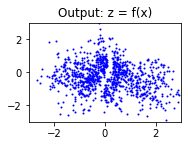

====> Test loss: -0.0596


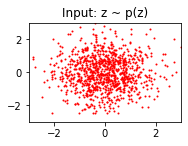

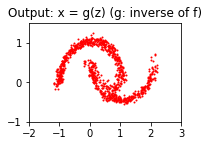

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.058396
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.059505
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.058815
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.058969
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.059211
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.058683
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.058597
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.059460
====> Epoch: 4 Average train loss: -0.0588


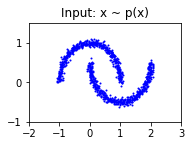

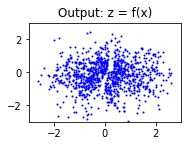

====> Test loss: -0.0607


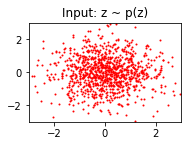

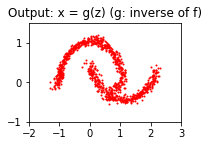

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.059175
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.057004
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.055787
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.058936
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.058307
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.059107
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.058735
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.059537
====> Epoch: 5 Average train loss: -0.0588


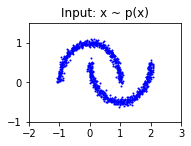

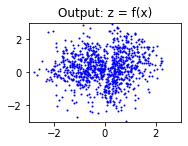

====> Test loss: -0.0603


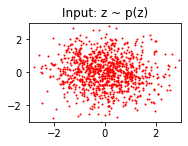

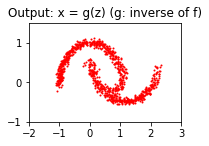

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.058701
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.057530
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.059453
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.059089
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.059662
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.059605
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.058311
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.059142
====> Epoch: 6 Average train loss: -0.0591


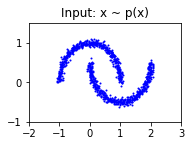

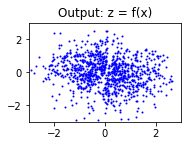

====> Test loss: -0.0611


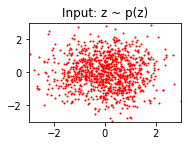

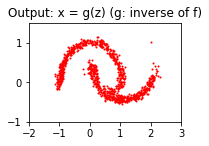

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.059962
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.059597
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.057022
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.060311
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.059038
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.059330
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.059021
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.059856
====> Epoch: 7 Average train loss: -0.0592


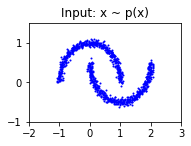

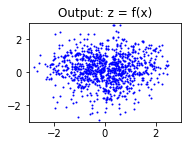

====> Test loss: -0.0611


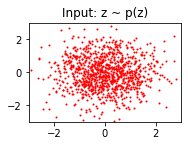

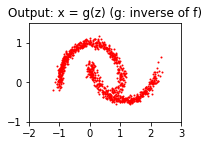

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.060044
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.059685
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.059720
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.060326
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.059377
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.058536
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.058341
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.058403
====> Epoch: 8 Average train loss: -0.0592


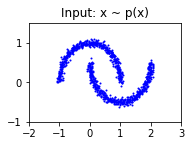

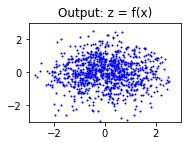

====> Test loss: -0.0614


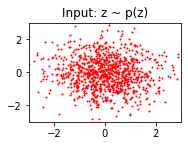

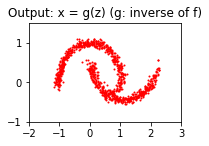

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.058872
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.059881
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.060092
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.058202
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.059781
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.058805
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.059499
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.060134
====> Epoch: 9 Average train loss: -0.0594


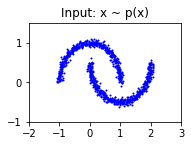

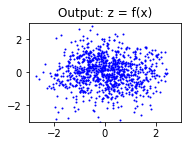

====> Test loss: -0.0613


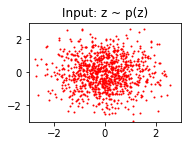

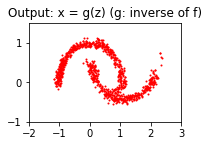

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.059623
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.059065
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.059940
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.057946
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.059038
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.059535
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.059709
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.059528
====> Epoch: 10 Average train loss: -0.0595


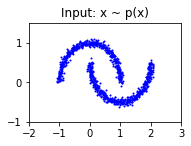

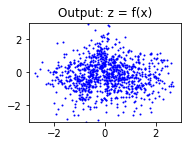

====> Test loss: -0.0611


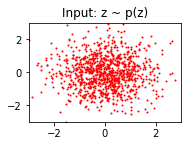

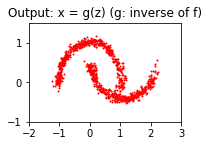

'416.87s'

<Figure size 432x288 with 0 Axes>

In [17]:
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in data**

> When there are many clusters in the data, the Normalizing flows may struggle to model all the clusters effectively, resulting in a mode collapse problem. This means that the model may generate samples that only represent a small subset of the clusters, or may generate samples that do not match the data distribution well. Moreover, points which don't belong to clusters will go far away: that will lead to gradient vanishing or exploding.

### Conclusion

**Q.27: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs and Normalizing flows ?**

> In this lab, we have implemented and compared the performances of three models: GANs, VAEs and Normalizing flows. Here is the conclusion we can have following our analysis:
> * GANs: GANs have several advantages: they can be used of very various applications, and are capable of generating high-quality, realistic images. However, they are very difficult to train, and it can take a lot of time. A big other problem of GANs is that they can be unstable and prone to mode collapse, where the generator produces a limited set of samples that do not represent the full data distribution.
> * VAEs: VAEs are very powerful tooks, because they can work with a lot of different data, whether they are labeled or not. A big drawback of VAEs is the fact that they can generate samples that are blurry or less sharp than GANs. This is caused by the way data distributions are recovered, and loss functions are calculated.
> * Normalizing flows: it is a very interesting model, which provide a robust distribution approximation. The main problem of normalizing flows method is that it is very computationally expensive, with models taking several times as long as GANs to generate images of the same resolution. These methods are moreover limited by density estimation performance issues compared to state-of-the-art autoregressive models, and they may suffer from the "bottleneck" problem, where the transformation function is forced to compress the information into a lower-dimensional space.